In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings

In [124]:
pip install stl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [125]:
# Load data
data = pd.read_csv('C:\\Users\\ACER\\Desktop\\studies\\TSF\\data-csv.csv', delimiter=';')

In [126]:
print("Initial data shape:", data.shape)

# Number of years of data used
years = 20

years_data = list(data.columns[ :3]) + list(data.columns[-years*12:])
data = data[years_data]

data.head()

Initial data shape: (260, 245)


nauja_naudota trans_tipas  \
0  Pirmą kartą šalyje įregistruotos kelių transpo...  Motociklai   
1  Pirmą kartą šalyje įregistruotos kelių transpo...  Motociklai   
2  Pirmą kartą šalyje įregistruotos kelių transpo...  Motociklai   
3  Pirmą kartą šalyje įregistruotos kelių transpo...  Motociklai   
4  Pirmą kartą šalyje įregistruotos kelių transpo...  Motociklai   

                              Tipas  2004M03  2004M04  2004M05  2004M06  \
0  Visos kelių transporto priemonės     75.0    219.0    188.0    179.0   
1                          Benzinas     75.0    219.0    188.0    179.0   
2                         Dyzelinas      NaN      NaN      NaN      NaN   
3                             Dujos      NaN      NaN      NaN      NaN   
4                Benzinas / Elektra      NaN      NaN      NaN      NaN   

   2004M07  2004M08  2004M09  ...  2023M05  2023M06  2023M07  2023M08  \
0    150.0    116.0     63.0  ...   1302.0   1176.0    841.0    758.0   
1    150.0    116.0     63.0  ...   1245.0   1108.0    792.0    685.0   
2      NaN      NaN      NaN  ...     28.0     37.0     22.0     36.0   
3      NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   
4      NaN      NaN      NaN  ...      NaN      NaN      NaN      NaN   

   2023M09  2023M10  2023M11  2023M12  2024M01  2024M02  
0    652.0    386.0    232.0    158.0    188.0    366.0  
1    555.0    322.0    174.0    112.0    151.0    315.0  
2     43.0     48.0     46.0     29.0     30.0     44.0  
3      NaN      NaN      NaN      NaN      NaN      NaN  
4      NaN      NaN      NaN      NaN      NaN      NaN  

[5 rows x 243 columns]

In [127]:
# Set appropriate fill rate threshold, now it is 100%
fill_rate_threshold = 1
data_filtered = data.dropna(thresh=int(fill_rate_threshold * data.shape[1]), axis=0)

# Make columns lower
data_filtered.columns = data_filtered.columns.str.lower()

# Display the shape of the cleaned data
print("Cleaned data shape:", data_filtered.shape)


# Display Unique Tipas
print(" Unique tipas counts: ",data_filtered.tipas.value_counts())

data_filtered = data_filtered[data_filtered['tipas']=='Visos kelių transporto priemonės']
# Display the first few rows of the cleaned data
display(data_filtered)

# updating the data
data_filtered = data_filtered.drop(columns=['tipas', 'nauja_naudota']).reset_index(drop=True)

# Dictionary to map Lithuanian letters to English equivalents
lithuanian_to_english = {
    'ą': 'a', 'č': 'c', 'ę': 'e', 'ė': 'e', 'į': 'i', 'š': 's', 'ų': 'u', 'ū': 'u', 'ž': 'z',
    'Ą': 'a', 'Č': 'c', 'Ę': 'e', 'Ė': 'e', 'Į': 'i', 'Š': 's', 'Ų': 'u', 'Ū': 'u', 'Ž': 'z'
}

# Function to replace Lithuanian letters
def replace_lithuanian_letters(text):
    for lithuanian_letter, english_letter in lithuanian_to_english.items():
        text = text.replace(lithuanian_letter, english_letter)
    return text

# Replace spaces with underscores, convert to lowercase, and replace Lithuanian letters
data_filtered['trans_tipas'] = (data_filtered['trans_tipas']
                                .str.replace(' ', '_')
                                .str.lower()
                                .apply(replace_lithuanian_letters))

# update index with 'trans_tipas' from the numerical analysis
df = data_filtered.set_index('trans_tipas').copy()

# Convert the columns to datetime index
df.columns = pd.to_datetime(df.columns.str.replace('m', '-'), format='%Y-%m')

df = df.T.copy()

# Display the rows of the cleaned data
display(df)

Cleaned data shape: (15, 243)
 Unique tipas counts:  tipas
Visos kelių transporto priemonės    8
Dyzelinas                           4
Benzinas                            3
Name: count, dtype: int64


nauja_naudota  \
0    Pirmą kartą šalyje įregistruotos kelių transpo...   
26   Pirmą kartą šalyje įregistruotos kelių transpo...   
39   Pirmą kartą šalyje įregistruotos kelių transpo...   
65   Pirmą kartą šalyje įregistruotos kelių transpo...   
78   Pirmą kartą šalyje įregistruotos kelių transpo...   
91   Pirmą kartą šalyje įregistruotos kelių transpo...   
104  Pirmą kartą šalyje įregistruotos kelių transpo...   
117  Pirmą kartą šalyje įregistruotos kelių transpo...   

                  trans_tipas                             tipas  2004m03  \
0                  Motociklai  Visos kelių transporto priemonės     75.0   
26     Lengvieji automobiliai  Visos kelių transporto priemonės  11277.0   
39                  Autobusai  Visos kelių transporto priemonės     95.0   
65   Krovininiai automobiliai  Visos kelių transporto priemonės    873.0   
78      Puspriekabių vilkikai  Visos kelių transporto priemonės    130.0   
91               Puspriekabės  Visos kelių transporto priemonės    148.0   
104                 Priekabos  Visos kelių transporto priemonės    117.0   
117    Specialūs automobiliai  Visos kelių transporto priemonės     64.0   

     2004m04  2004m05  2004m06  2004m07  2004m08  2004m09  ...  2023m05  \
0      219.0    188.0    179.0    150.0    116.0     63.0  ...   1302.0   
26   13657.0  12371.0  13112.0  13436.0  11805.0  11228.0  ...  11478.0   
39     127.0     73.0     63.0     74.0    134.0    102.0  ...     57.0   
65    1000.0    879.0    928.0   1000.0    882.0    892.0  ...   1046.0   
78     165.0    233.0    206.0    205.0    149.0    211.0  ...    994.0   
91     146.0    187.0    191.0    165.0    131.0    265.0  ...    882.0   
104    174.0    183.0    173.0    212.0    187.0    191.0  ...    156.0   
117     90.0     84.0     95.0     91.0     81.0     92.0  ...    136.0   

     2023m06  2023m07  2023m08  2023m09  2023m10  2023m11  2023m12  2024m01  \
0     1176.0    841.0    758.0    652.0    386.0    232.0    158.0    188.0   
26   11479.0  10613.0  10954.0  10441.0  10358.0   9586.0   8892.0   8762.0   
39      33.0     56.0    104.0     44.0     44.0     48.0     40.0     46.0   
65    1074.0    949.0   1083.0    920.0   1018.0   1020.0    873.0   1004.0   
78    1025.0    827.0    697.0    885.0   1205.0    819.0    532.0    527.0   
91     599.0    652.0    552.0    652.0    706.0    468.0    323.0    376.0   
104    168.0    152.0    146.0     93.0    185.0    152.0    102.0    163.0   
117    224.0    141.0    143.0     94.0    100.0     98.0    106.0     98.0   

     2024m02  
0      366.0  
26    9407.0  
39      47.0  
65    1208.0  
78     755.0  
91     474.0  
104    131.0  
117     88.0  

[8 rows x 243 columns]

trans_tipas  motociklai  lengvieji_automobiliai  autobusai  \
2004-03-01         75.0                 11277.0       95.0   
2004-04-01        219.0                 13657.0      127.0   
2004-05-01        188.0                 12371.0       73.0   
2004-06-01        179.0                 13112.0       63.0   
2004-07-01        150.0                 13436.0       74.0   
...                 ...                     ...        ...   
2023-10-01        386.0                 10358.0       44.0   
2023-11-01        232.0                  9586.0       48.0   
2023-12-01        158.0                  8892.0       40.0   
2024-01-01        188.0                  8762.0       46.0   
2024-02-01        366.0                  9407.0       47.0   

trans_tipas  krovininiai_automobiliai  puspriekabiu_vilkikai  puspriekabes  \
2004-03-01                      873.0                  130.0         148.0   
2004-04-01                     1000.0                  165.0         146.0   
2004-05-01                      879.0                  233.0         187.0   
2004-06-01                      928.0                  206.0         191.0   
2004-07-01                     1000.0                  205.0         165.0   
...                               ...                    ...           ...   
2023-10-01                     1018.0                 1205.0         706.0   
2023-11-01                     1020.0                  819.0         468.0   
2023-12-01                      873.0                  532.0         323.0   
2024-01-01                     1004.0                  527.0         376.0   
2024-02-01                     1208.0                  755.0         474.0   

trans_tipas  priekabos  specialus_automobiliai  
2004-03-01       117.0                    64.0  
2004-04-01       174.0                    90.0  
2004-05-01       183.0                    84.0  
2004-06-01       173.0                    95.0  
2004-07-01       212.0                    91.0  
...                ...                     ...  
2023-10-01       185.0                   100.0  
2023-11-01       152.0                    98.0  
2023-12-01       102.0                   106.0  
2024-01-01       163.0                    98.0  
2024-02-01       131.0                    88.0  

[240 rows x 8 columns]

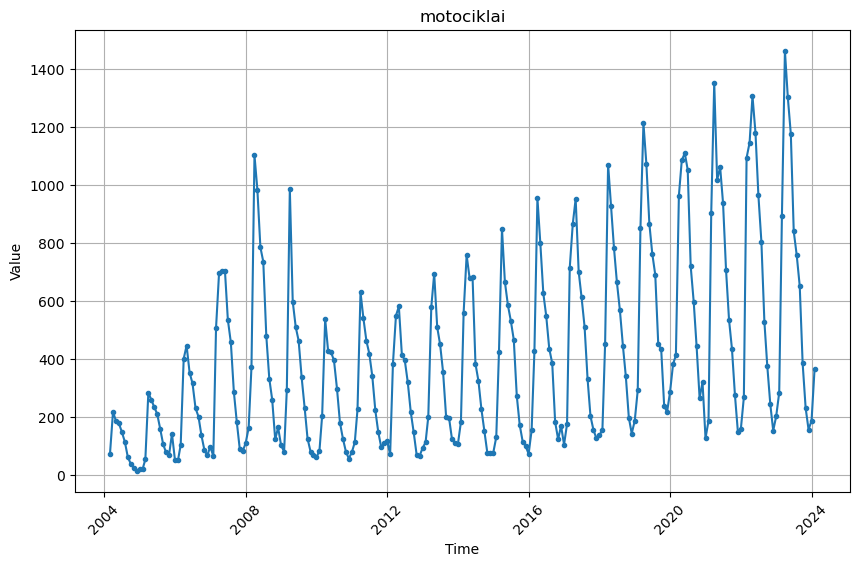

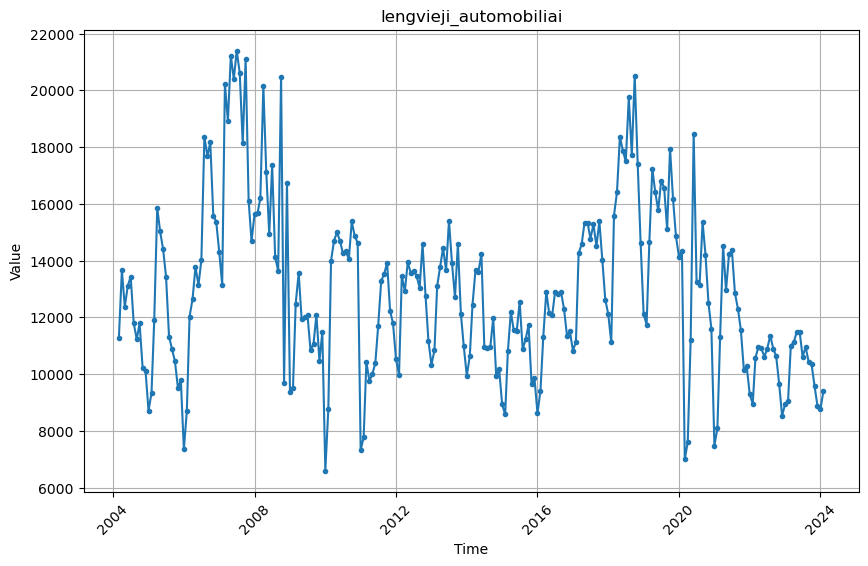

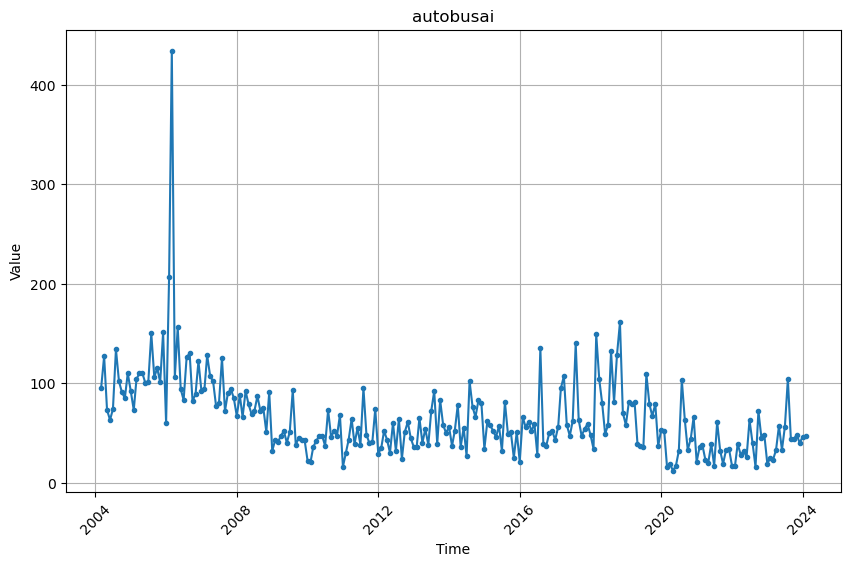

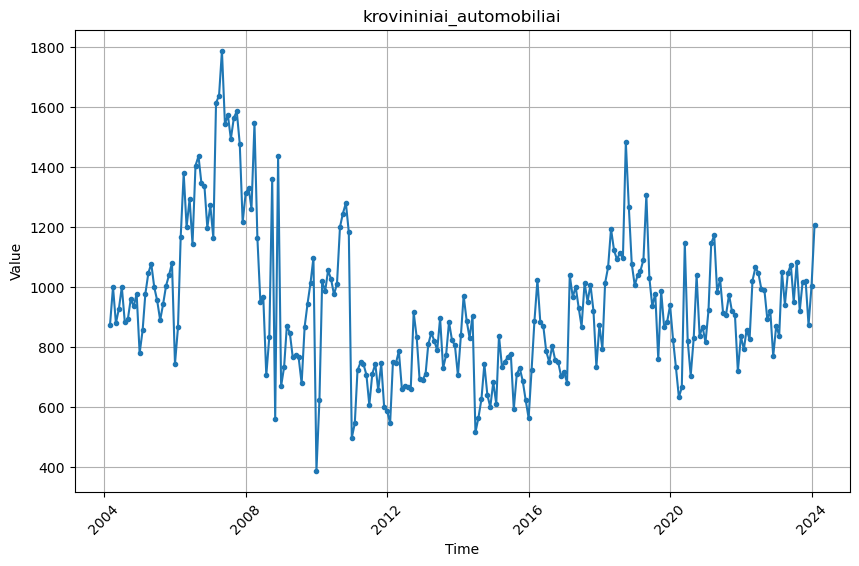

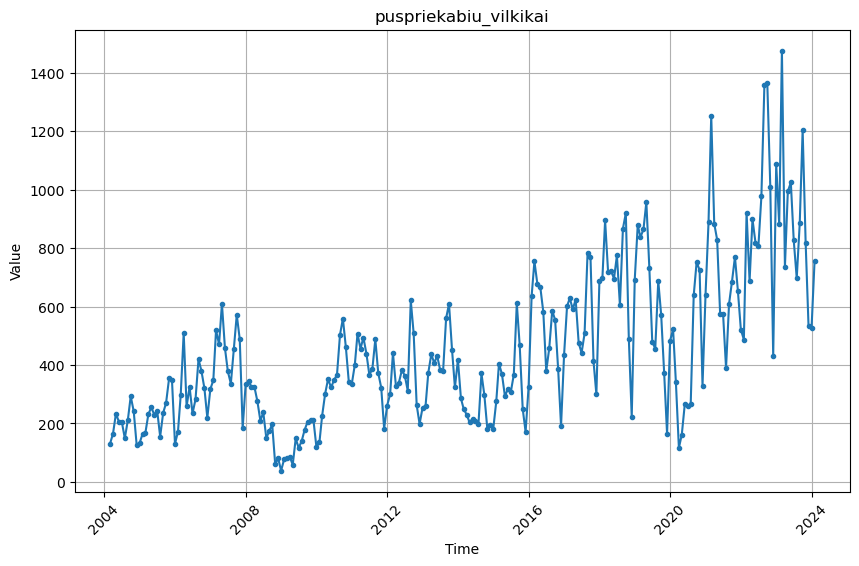

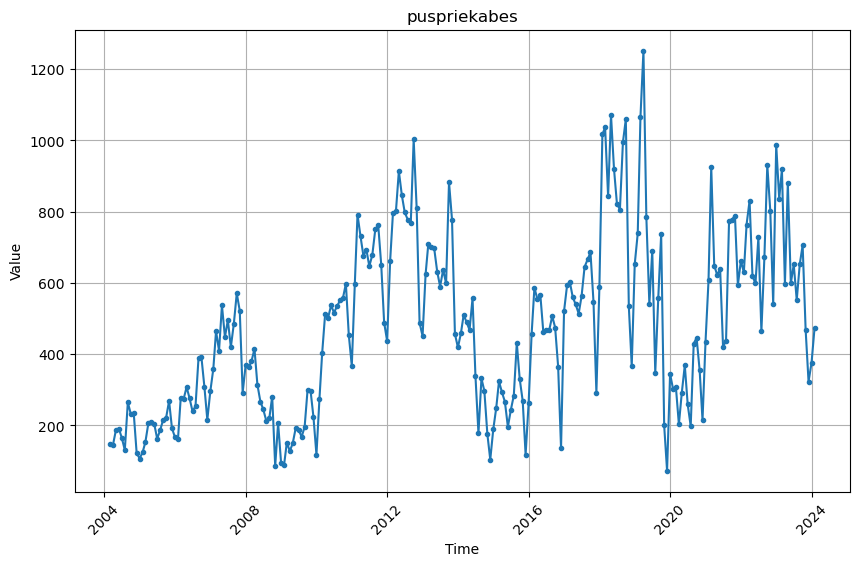

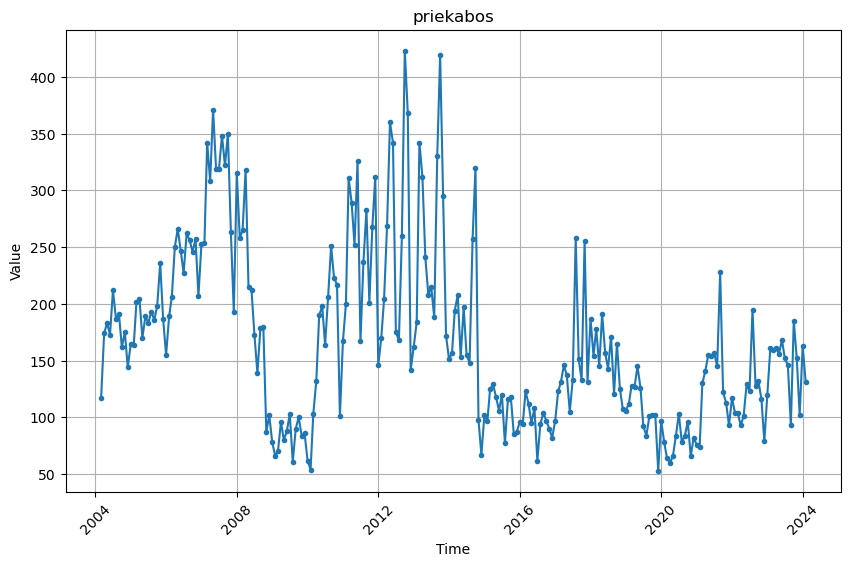

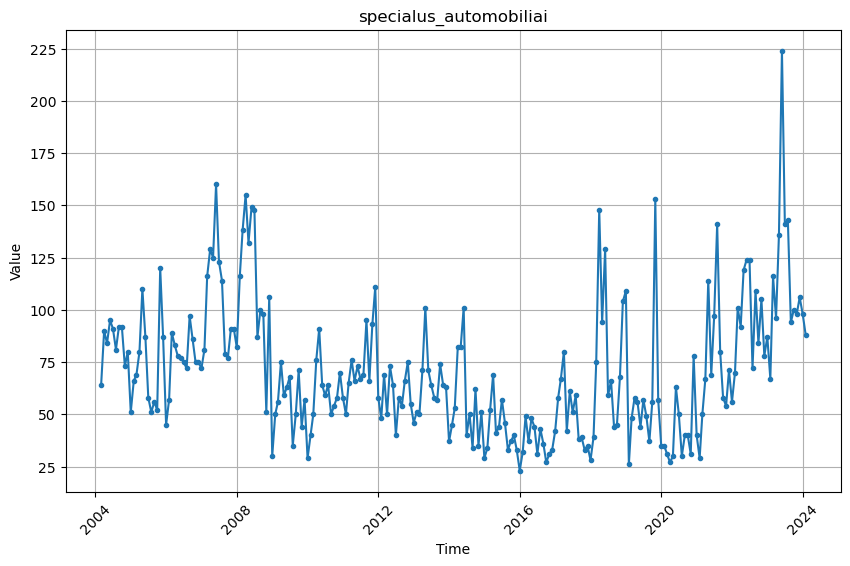

In [128]:
# Plot each column over time
for column in df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[column], marker='o', markersize=3)
    plt.title(column)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


Initial Stationarity Check:

                         ADF p-value KPSS p-value Is Stationary
motociklai                  0.715676         0.01         False
lengvieji_automobiliai      0.090978          1.0         False
autobusai                   0.440113      0.01027         False
krovininiai_automobiliai    0.086886      0.03464         False
puspriekabiu_vilkikai       0.133862         0.01         False
puspriekabes                0.022639         0.01         False
priekabos                   0.011106     0.033311         False
specialus_automobiliai      0.000013         0.01         False


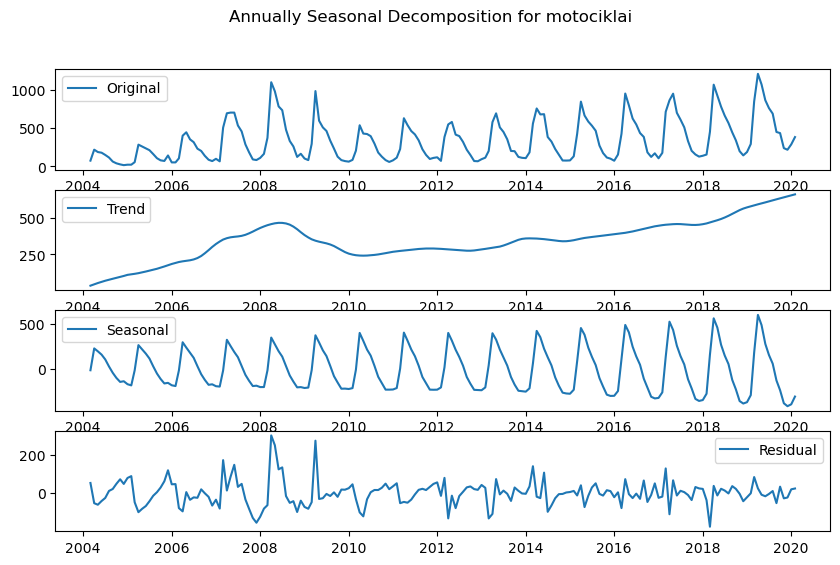

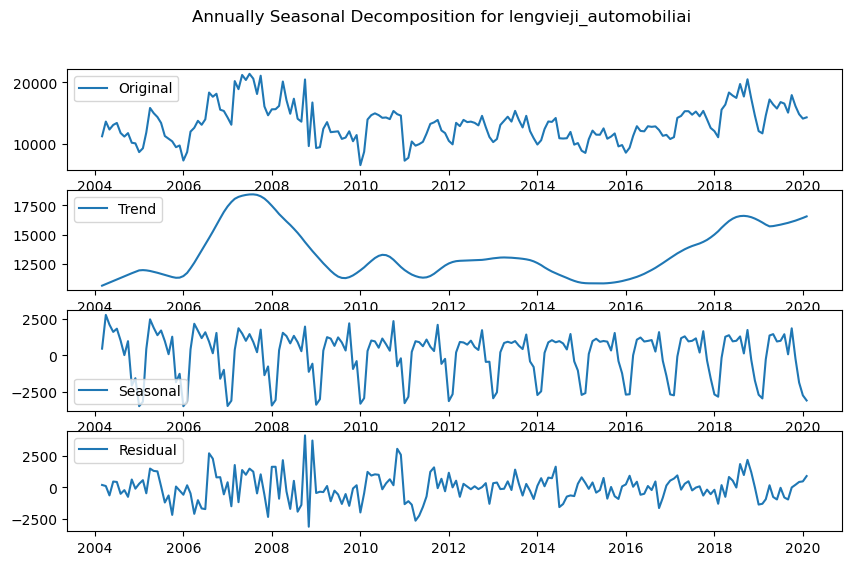

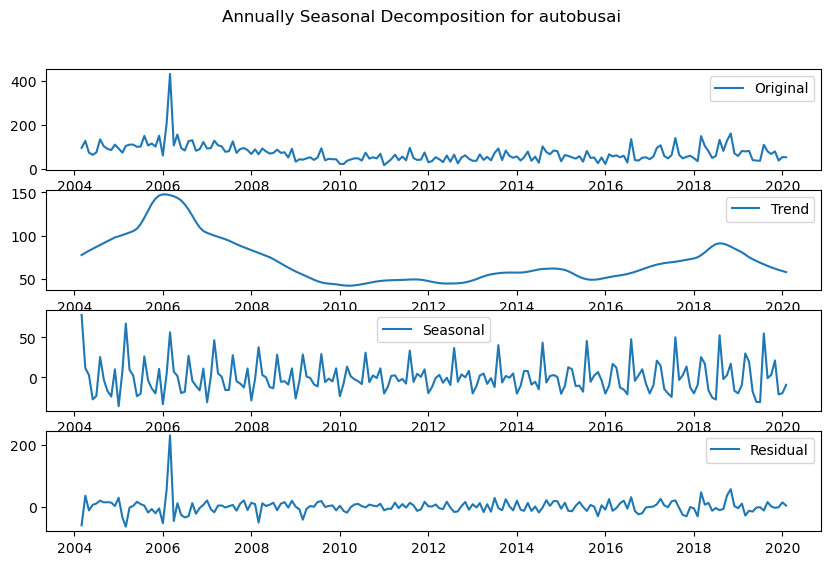

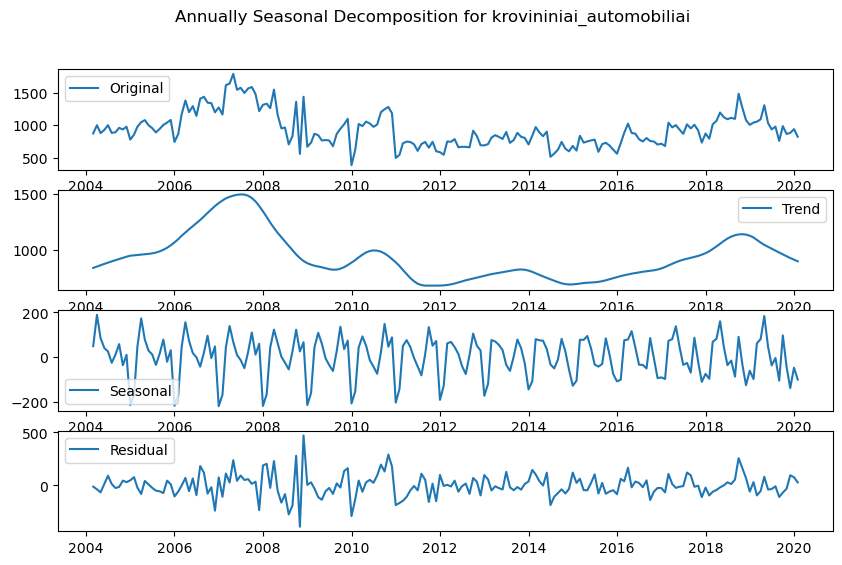

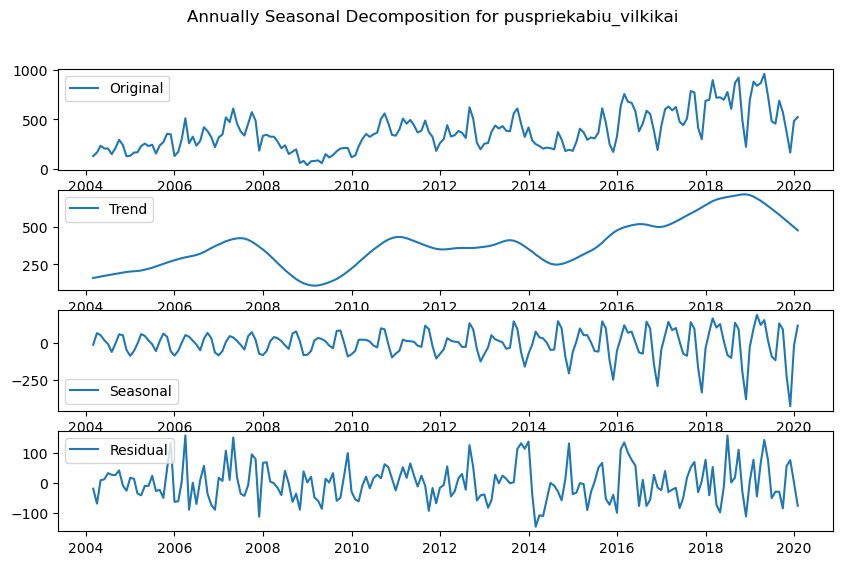

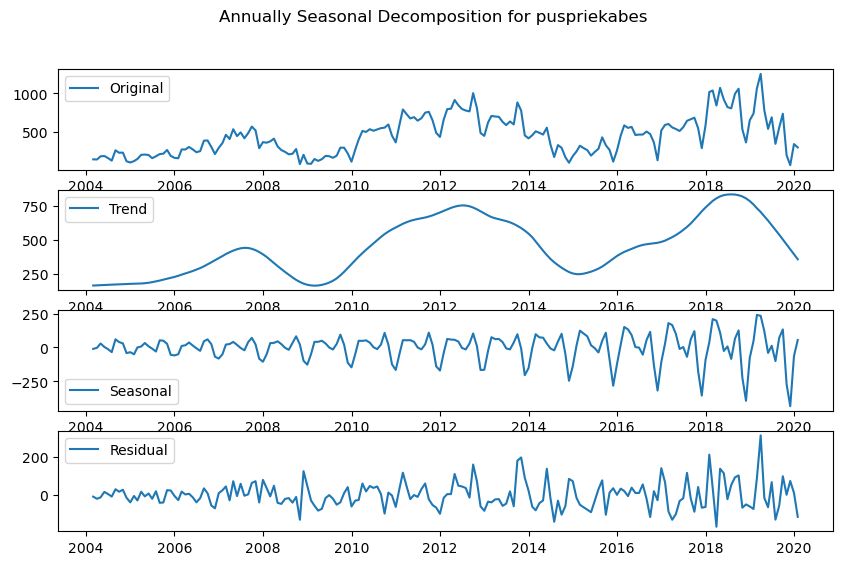

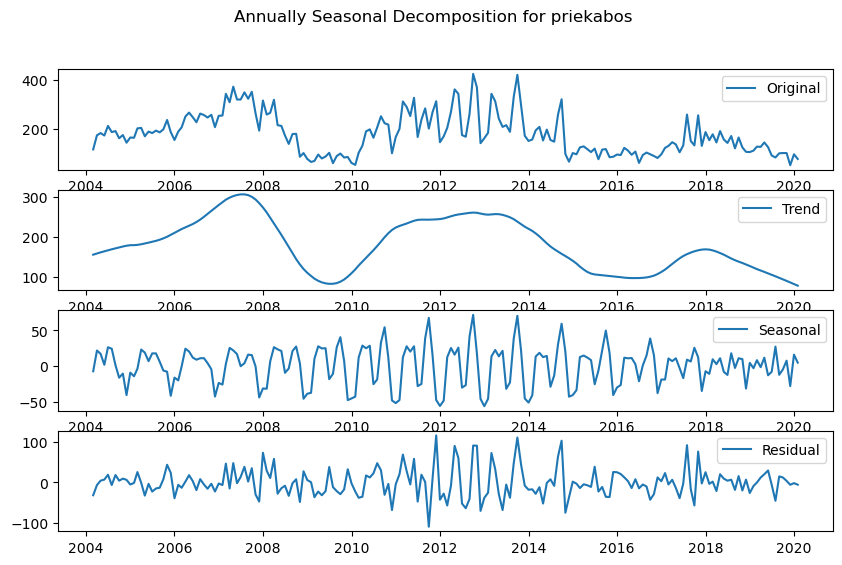

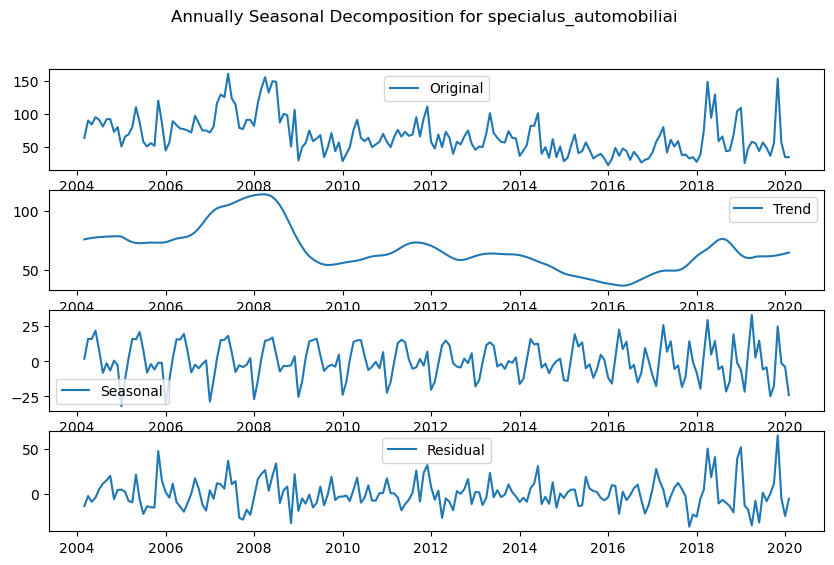

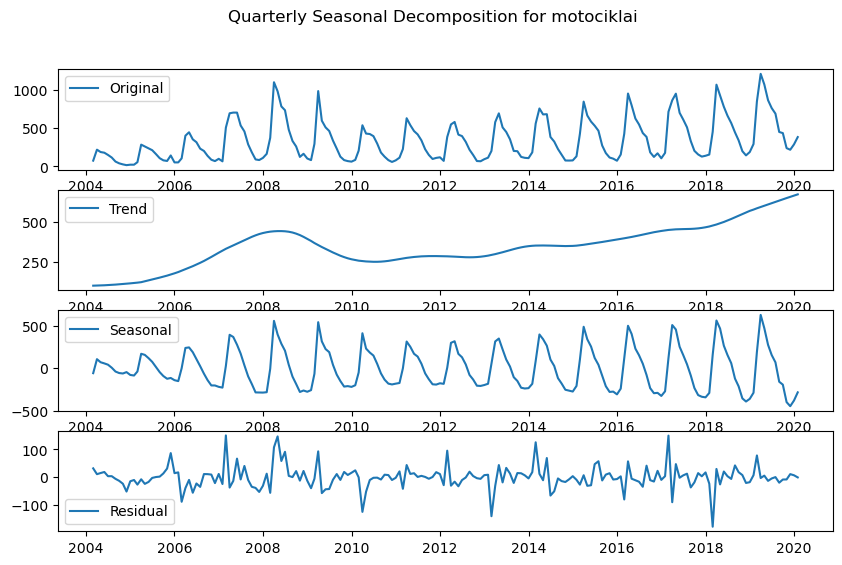

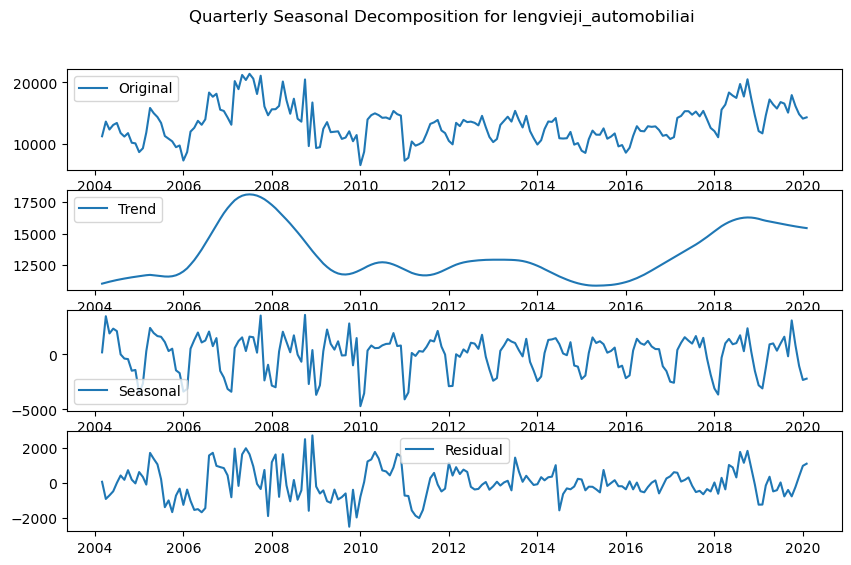

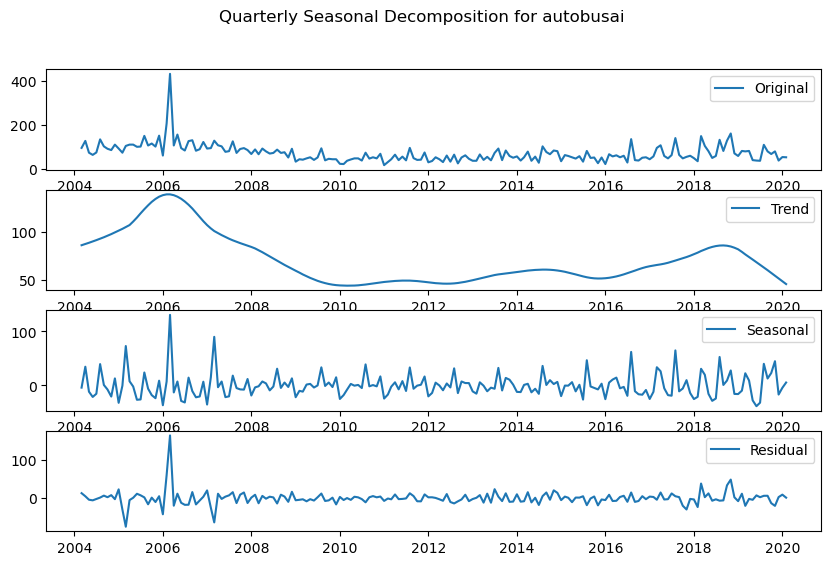

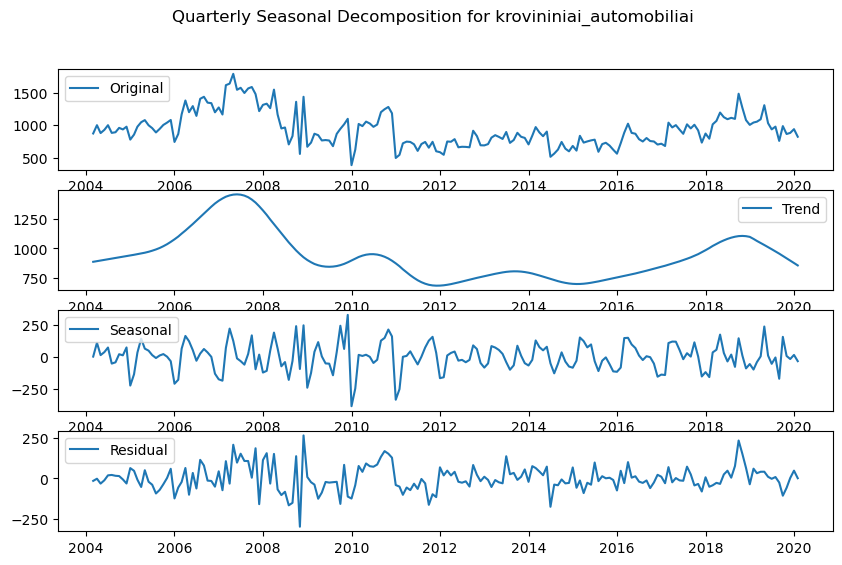

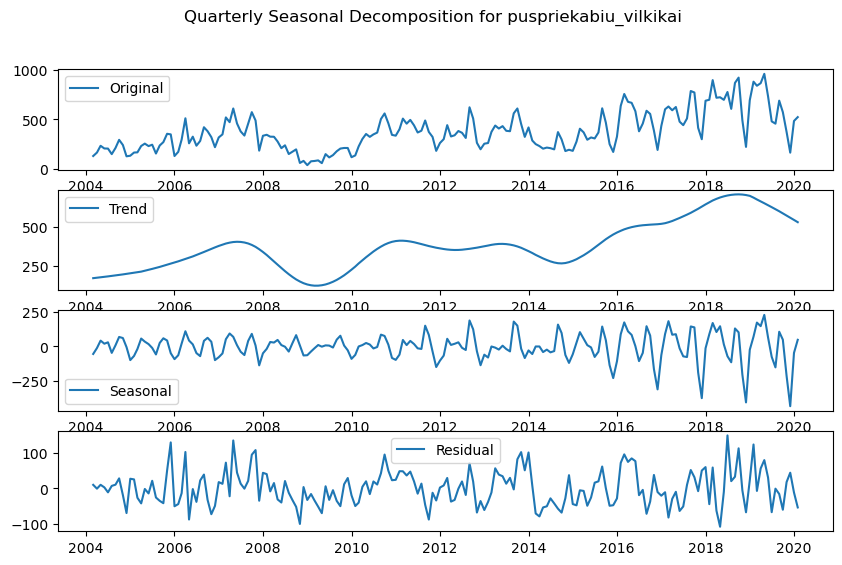

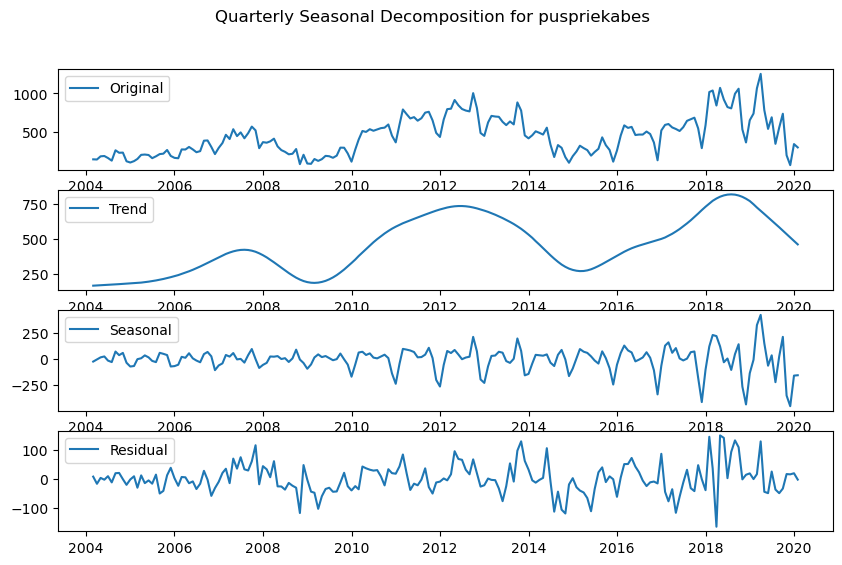

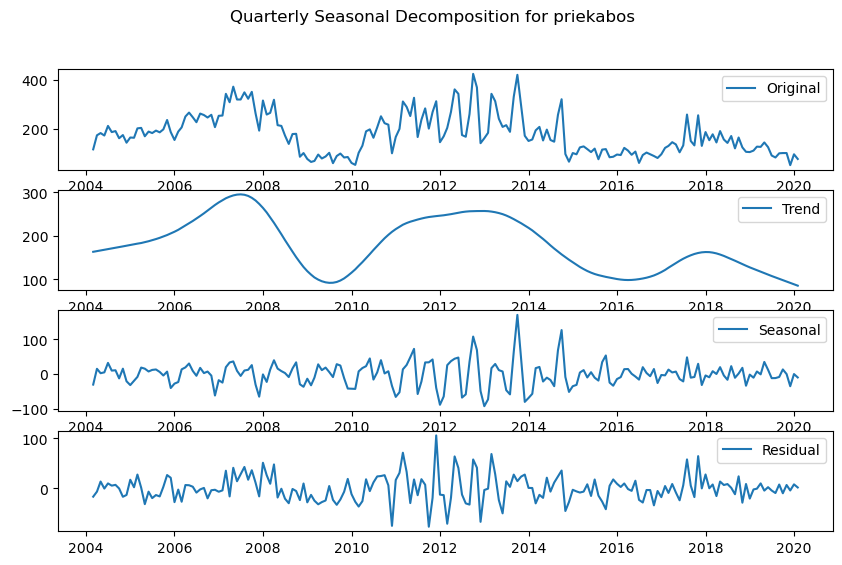

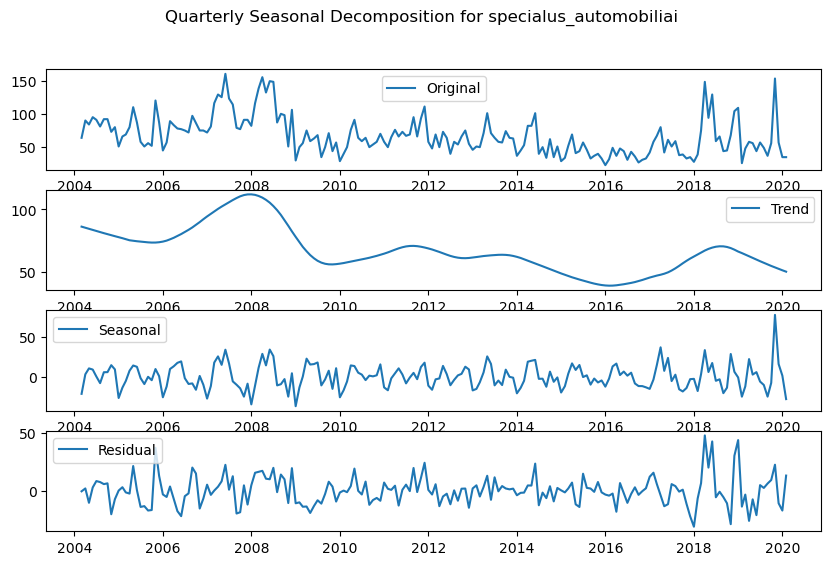

                                   ADF p-value KPSS p-value Is Stationary
Annually_motociklai                   0.861796         0.01         False
Annually_lengvieji_automobiliai       0.271924          1.0         False
Annually_autobusai                    0.009805     0.013062         False
Annually_krovininiai_automobiliai     0.215604     0.049467         False
Annually_puspriekabiu_vilkikai        0.227212         0.01         False
Annually_puspriekabes                 0.058359         0.01         False
Annually_priekabos                    0.008269       0.0438         False
Annually_specialus_automobiliai       0.087756         0.01         False
Quarterly_motociklai                  0.720207         0.01         False
Quarterly_lengvieji_automobiliai       0.33516          1.0         False
Quarterly_autobusai                   0.515115         0.01         False
Quarterly_krovininiai_automobiliai    0.321549     0.044514         False
Quarterly_puspriekabiu_vilkikai       

ADF p-value KPSS p-value Is Stationary
motociklai                  0.861796         0.01         False
lengvieji_automobiliai      0.271924          1.0         False
autobusai                   0.009805     0.013062         False
krovininiai_automobiliai    0.215604     0.049467         False
puspriekabiu_vilkikai       0.227212         0.01         False
puspriekabes                0.058359         0.01         False
priekabos                   0.008269       0.0438         False
specialus_automobiliai      0.087756         0.01         False


Stationarity Check for Deseasonalized and Detrended Data:



ADF p-value KPSS p-value Is Stationary
motociklai                       0.0          1.0          True
lengvieji_automobiliai           0.0          1.0          True
autobusai                        0.0          1.0          True
krovininiai_automobiliai    0.000001          1.0          True
puspriekabiu_vilkikai            0.0          1.0          True
puspriekabes                     0.0          1.0          True
priekabos                    0.00305          1.0          True
specialus_automobiliai           0.0          1.0          True


Variance Inflation Factor (VIF):



variables       VIF
0                motociklai  1.130434
1    lengvieji_automobiliai  2.568048
2                 autobusai  1.059053
3  krovininiai_automobiliai  2.595502
4     puspriekabiu_vilkikai  1.320779
5              puspriekabes  1.366190
6                 priekabos  1.226978
7    specialus_automobiliai  1.173797

Final DataFrame after VIF reduction:


trans_tipas  motociklai  lengvieji_automobiliai  autobusai  \
2004-03-01    52.318619              195.828964 -60.745754   
2004-04-01   -52.676353              110.364766  35.168222   
2004-05-01   -60.566640             -637.290053 -12.549650   
2004-06-01   -41.283314              469.094564   5.461645   
2004-07-01   -25.528426              434.792904   9.978602   
...                 ...                     ...        ...   
2019-10-01    33.175961               -4.157543   0.466959   
2019-11-01   -27.491822              210.313994  -4.092143   
2019-12-01   -23.143071              434.385259  -2.308253   
2020-01-01    19.365126              481.441503  13.511990   
2020-02-01    23.612282              904.350427   3.290504   

trans_tipas  krovininiai_automobiliai  puspriekabiu_vilkikai  puspriekabes  \
2004-03-01                 -12.348847             -18.756174     -7.637416   
2004-04-01                 -37.453592             -68.337222    -18.989879   
2004-05-01                 -65.917259               9.179991    -11.250996   
2004-06-01                  14.921814              12.314433     16.963771   
2004-07-01                  90.614019              32.815829      6.024019   
...                               ...                    ...           ...   
2019-10-01                 -68.110940             -83.740656     98.337738   
2019-11-01                 -32.067352              56.538446      2.054323   
2019-12-01                  95.177019              76.029482     73.788142   
2020-01-01                  76.169252               1.515117     11.583138   
2020-02-01                  27.658904             -75.450373   -112.826688   

trans_tipas  priekabos  specialus_automobiliai  
2004-03-01  -31.451444              -13.838616  
2004-04-01   -6.392000               -2.605854  
2004-05-01    4.462141               -9.121148  
2004-06-01    7.129160               -4.439021  
2004-07-01   19.063028                5.011356  
...                ...                     ...  
2019-10-01   12.365648               11.223147  
2019-11-01    3.911302               65.448683  
2019-12-01   -5.654384               -4.963859  
2020-01-01   -1.602366              -25.092571  
2020-02-01   -5.462216               -5.790386  

[192 rows x 8 columns]


Final VIF values:


variables       VIF
0                motociklai  1.130434
1    lengvieji_automobiliai  2.568048
2                 autobusai  1.059053
3  krovininiai_automobiliai  2.595502
4     puspriekabiu_vilkikai  1.320779
5              puspriekabes  1.366190
6                 priekabos  1.226978
7    specialus_automobiliai  1.173797

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 31, May, 2024
Time:                     22:45:51
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    79.6826
Nobs:                     177.000    HQIC:                   69.3571
Log likelihood:          -6555.87    FPE:                1.31806e+28
AIC:                      62.3125    Det(Omega_mle):     2.04170e+26
--------------------------------------------------------------------
Results for equation motociklai
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               -0.386029         3.442211           -0.112           0.911
L1.motociklai                       -0.083562         0.128732           -0.649           0


ARCH Test Results:



Lagrange Multiplier p-value  F-statistic p-value
motociklai                                   0.524011             0.537051
lengvieji_automobiliai                       0.805590             0.818085
autobusai                                    0.669680             0.684180
krovininiai_automobiliai                     0.670493             0.684991
puspriekabiu_vilkikai                        0.308650             0.314576
puspriekabes                                 0.061619             0.057740
priekabos                                    0.339424             0.346639
specialus_automobiliai                       0.712181             0.726449


Johansen Cointegration Test:



Trace Statistic  Critical Value (5%)  Is Cointegrated
0       729.994874             143.6691             True
1       566.521053             111.7797             True
2       437.174983              83.9383             True
3       328.810503              60.0627             True
4       232.991451              40.1749             True
5       161.312442              24.2761             True
6        94.677701              12.3212             True
7        41.876645               4.1296             True

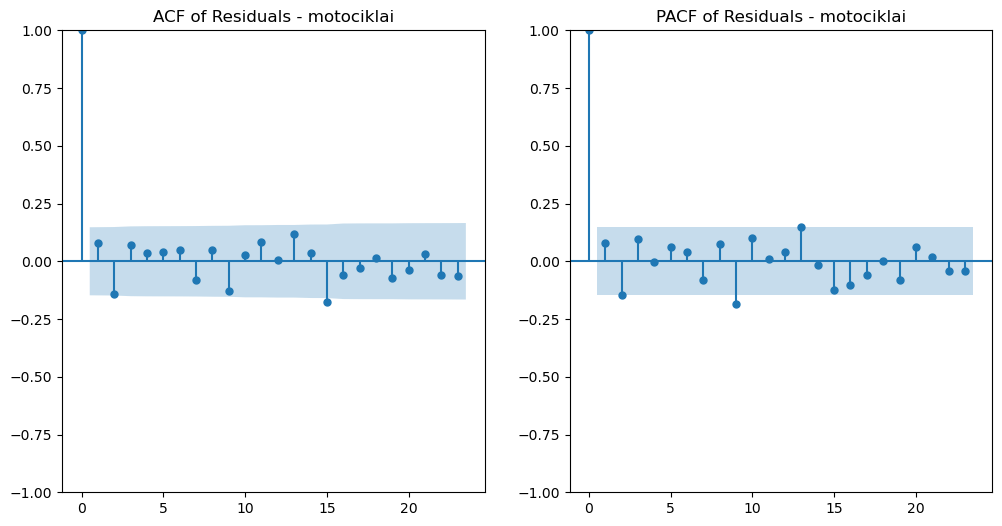

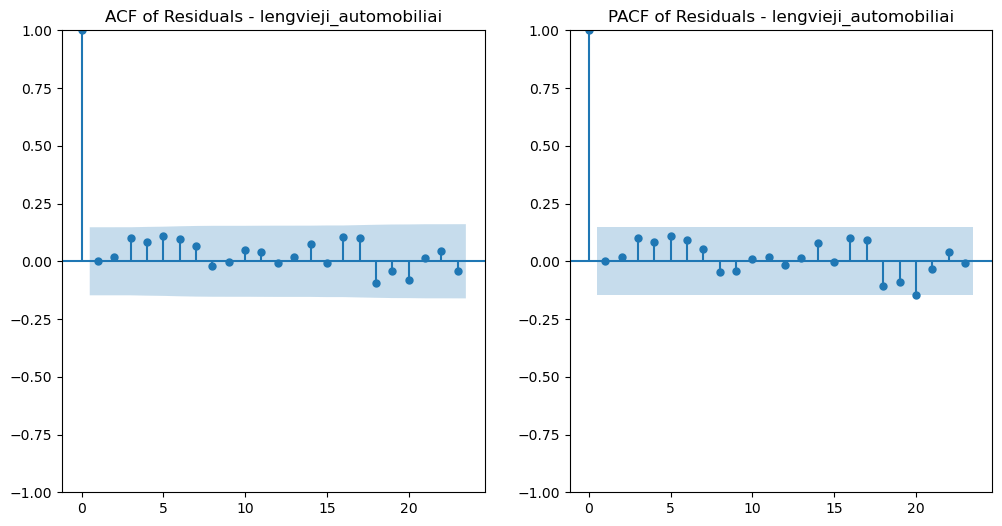

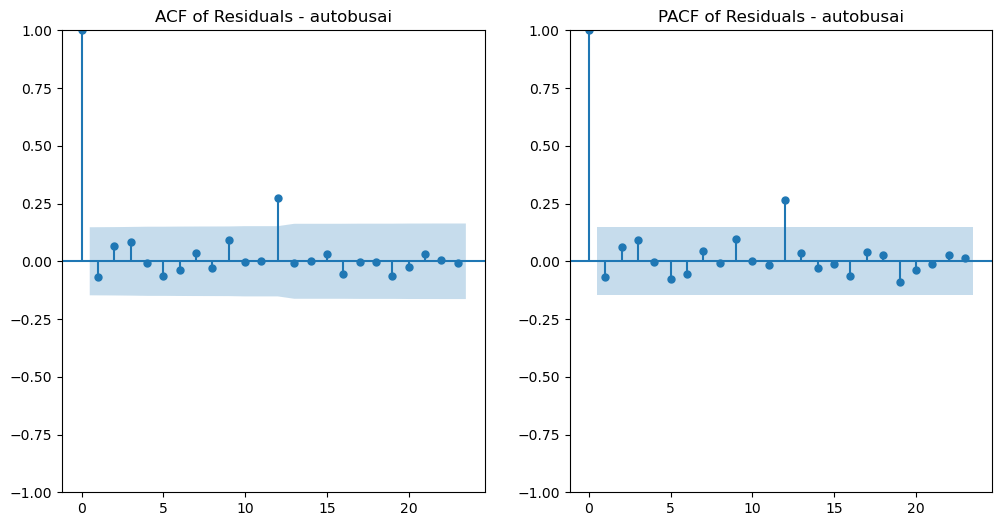

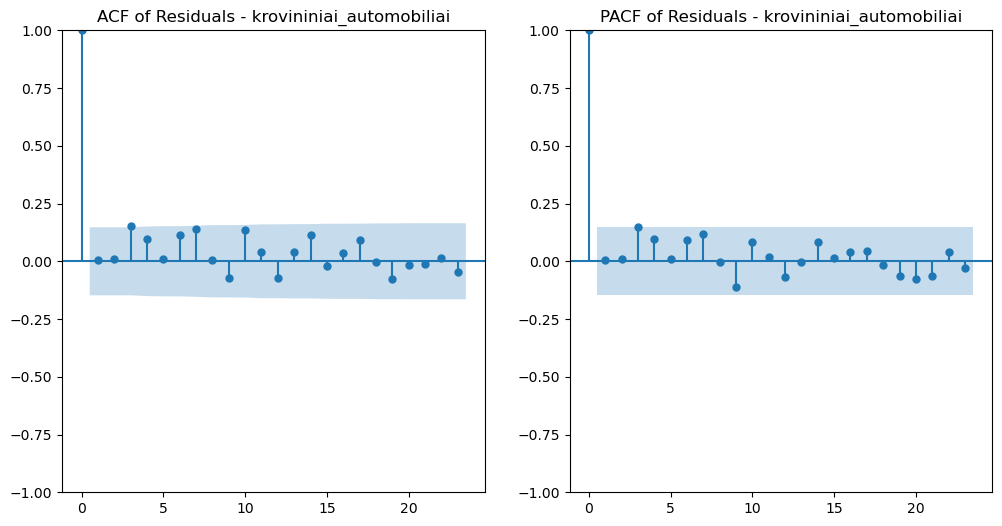

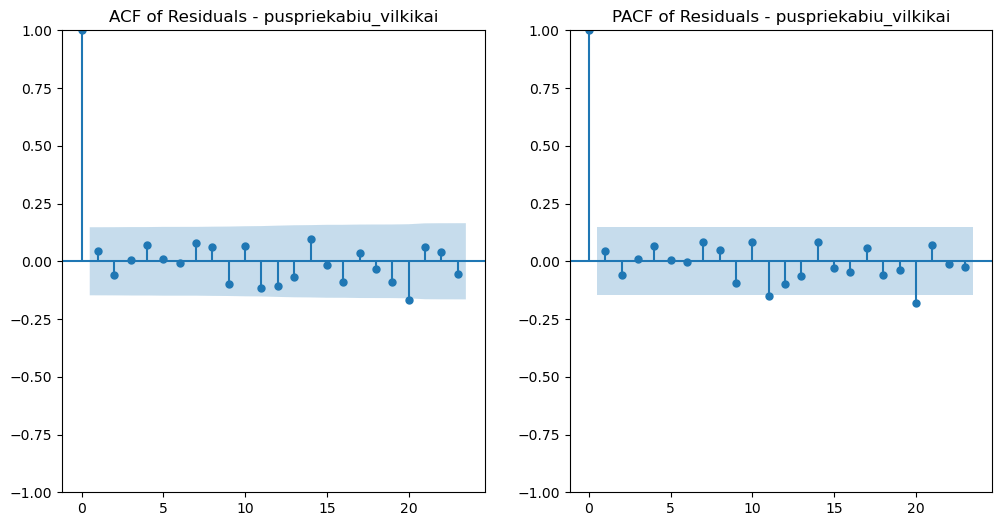

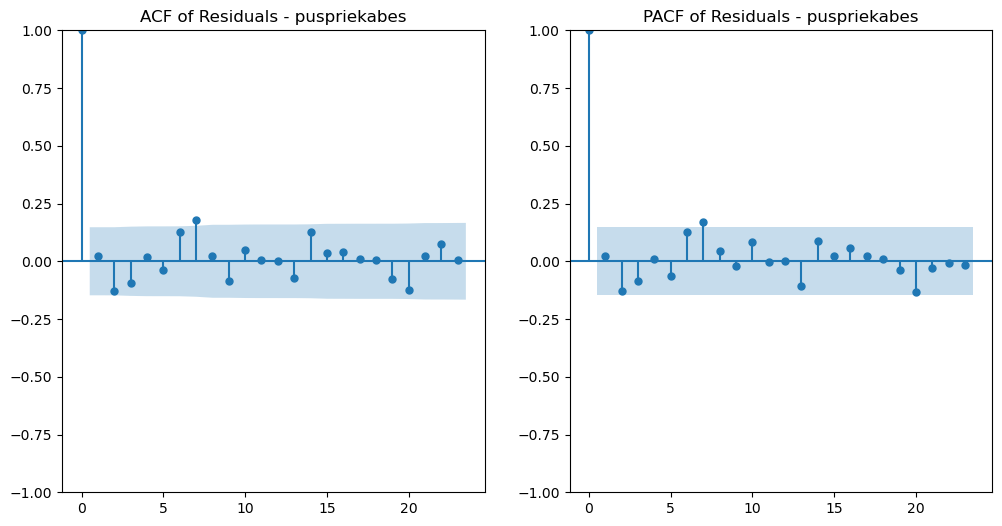

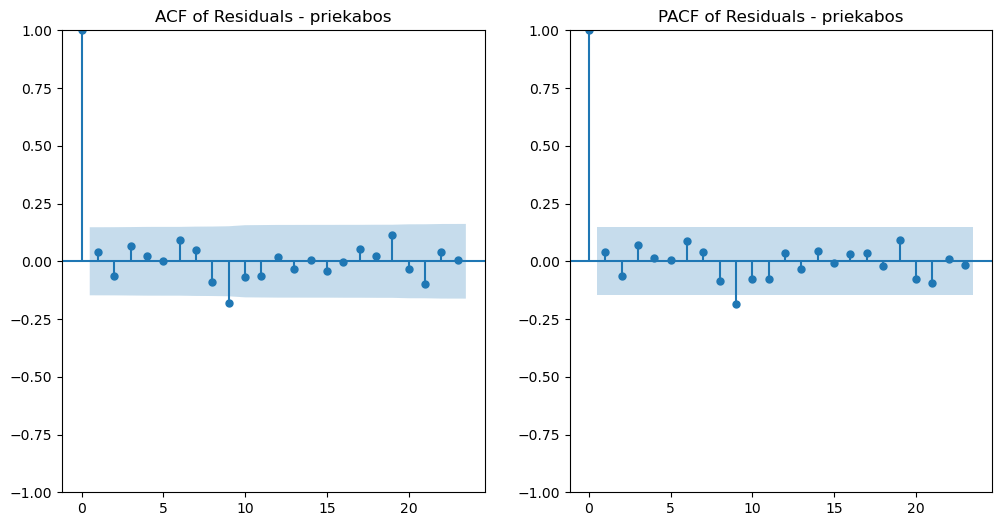

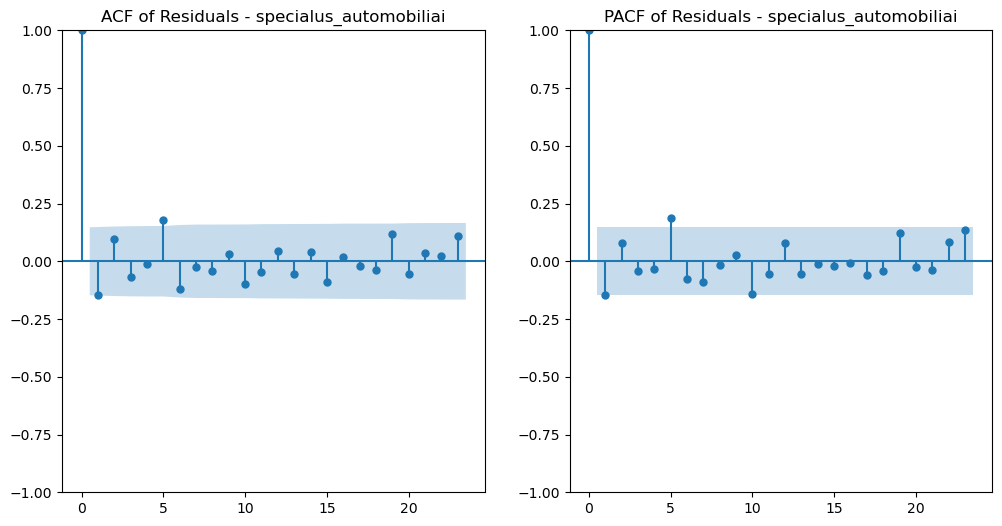

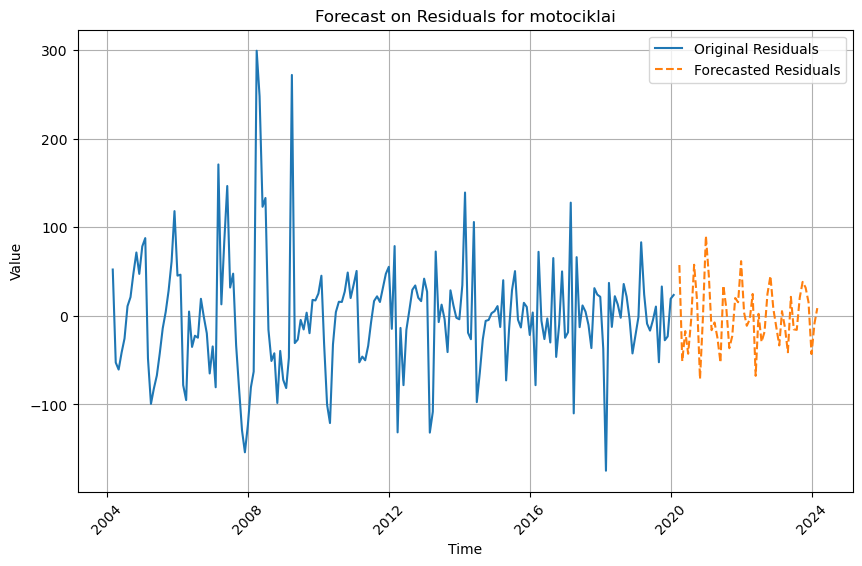

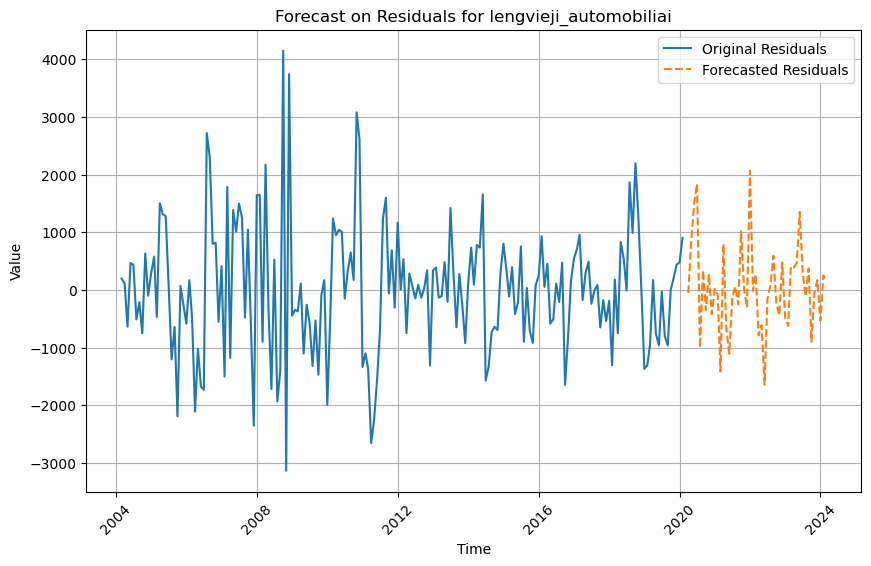

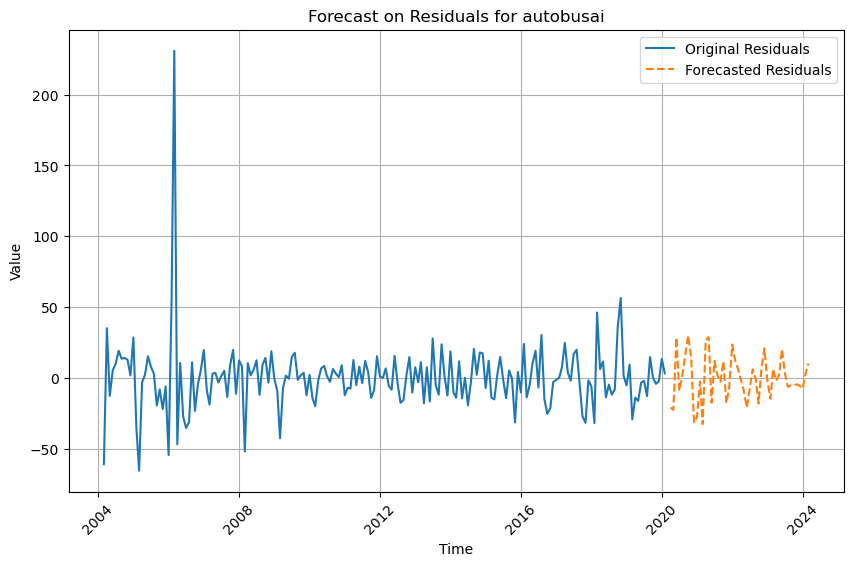

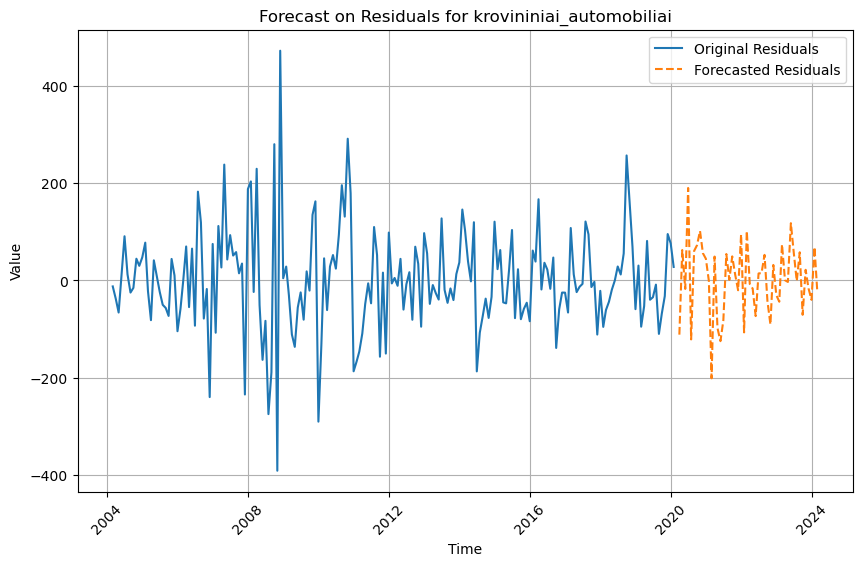

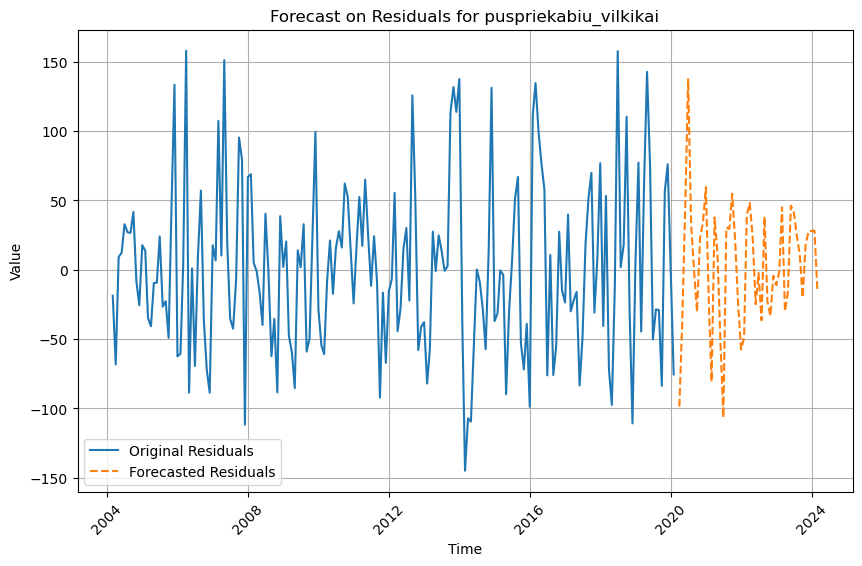

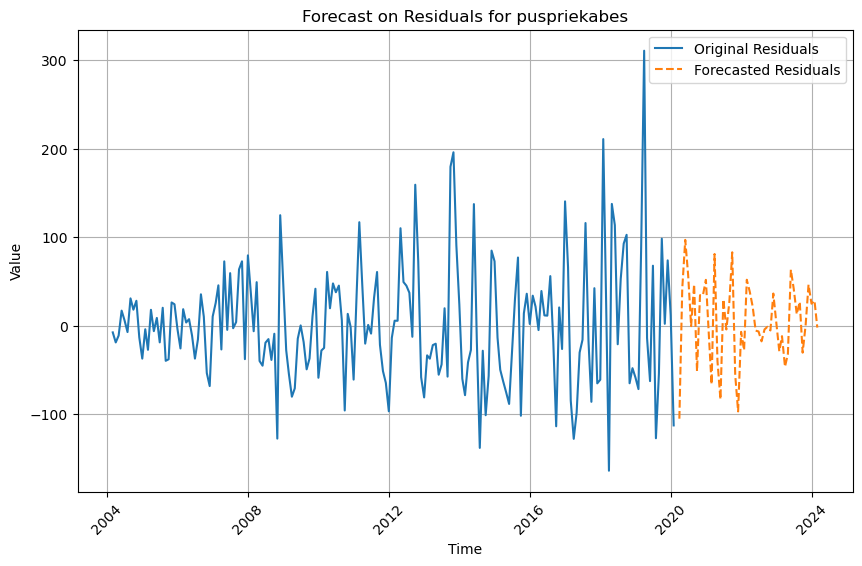

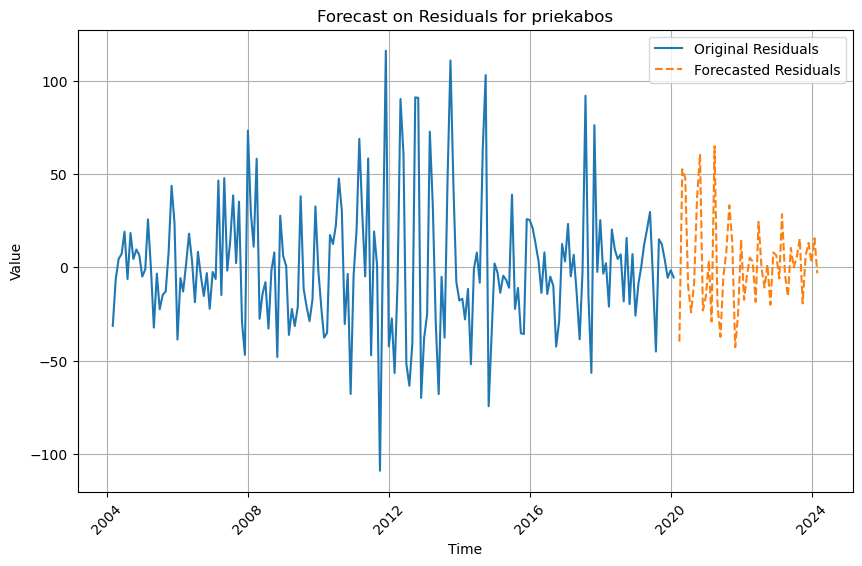

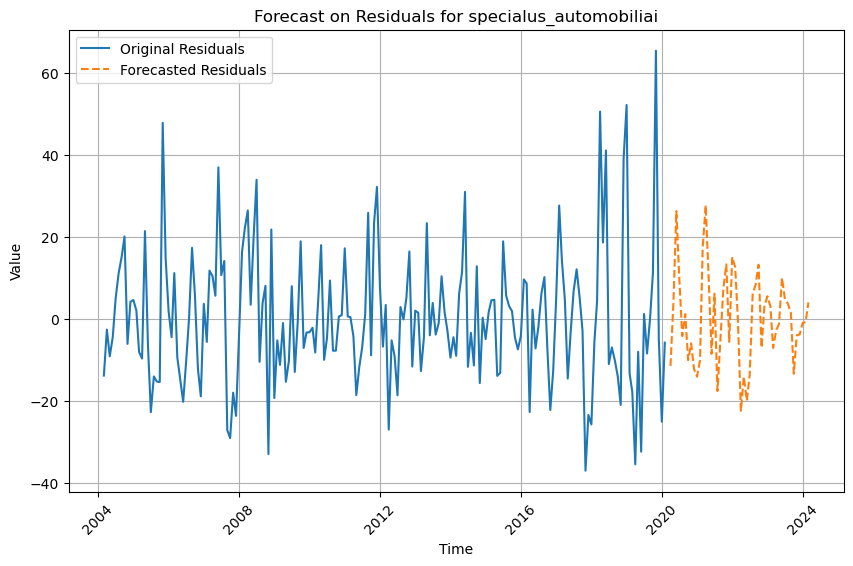

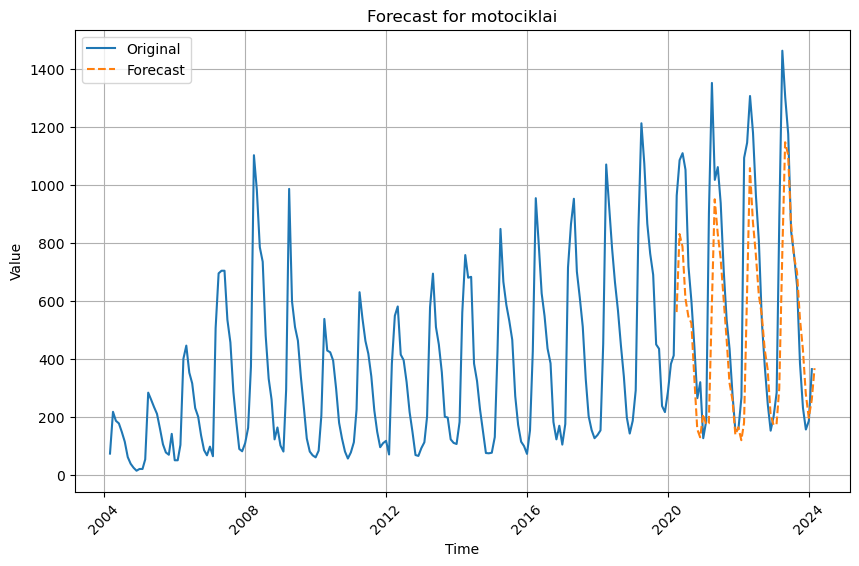

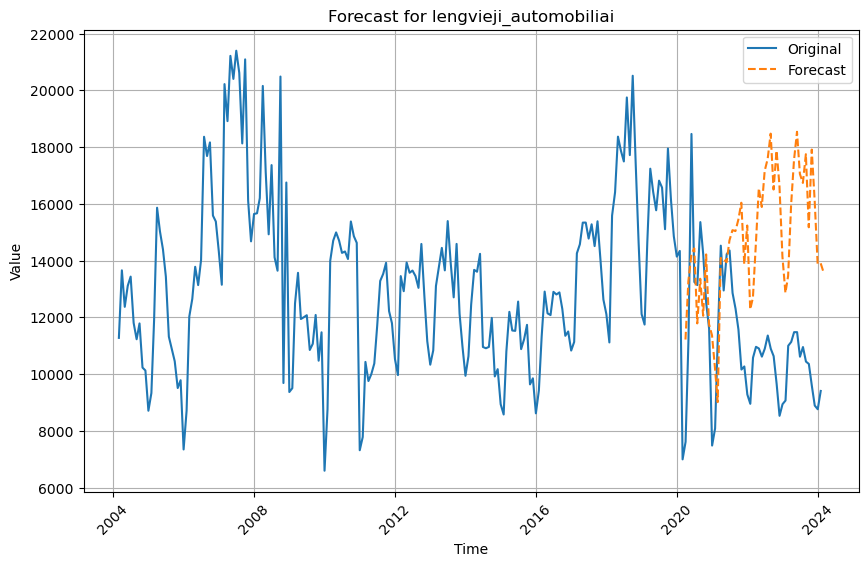

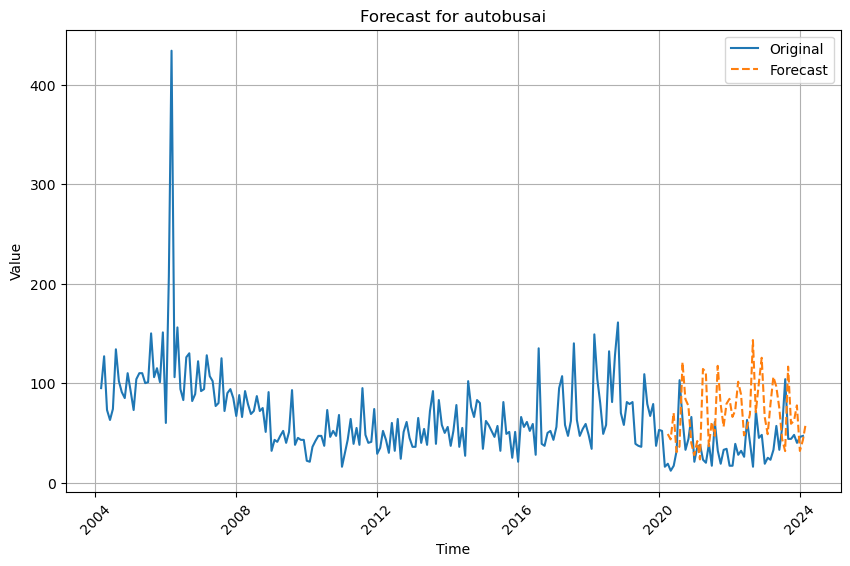

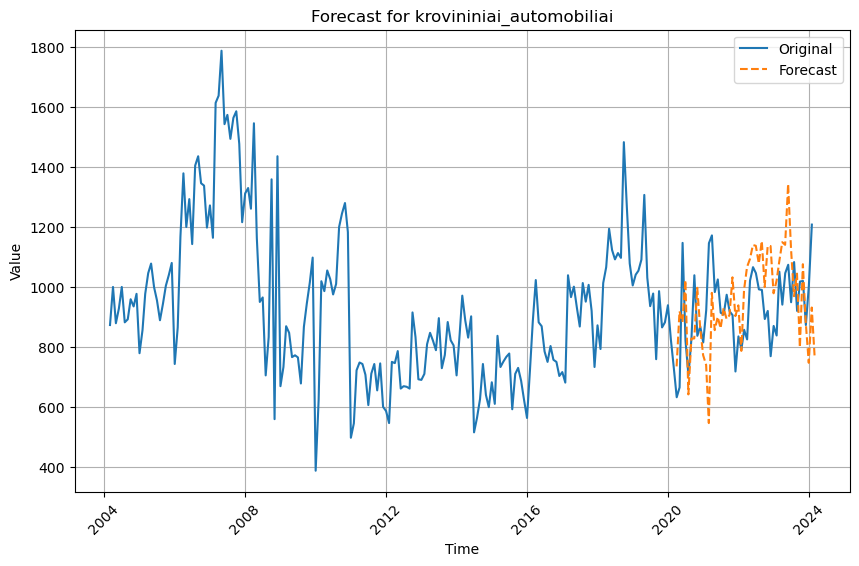

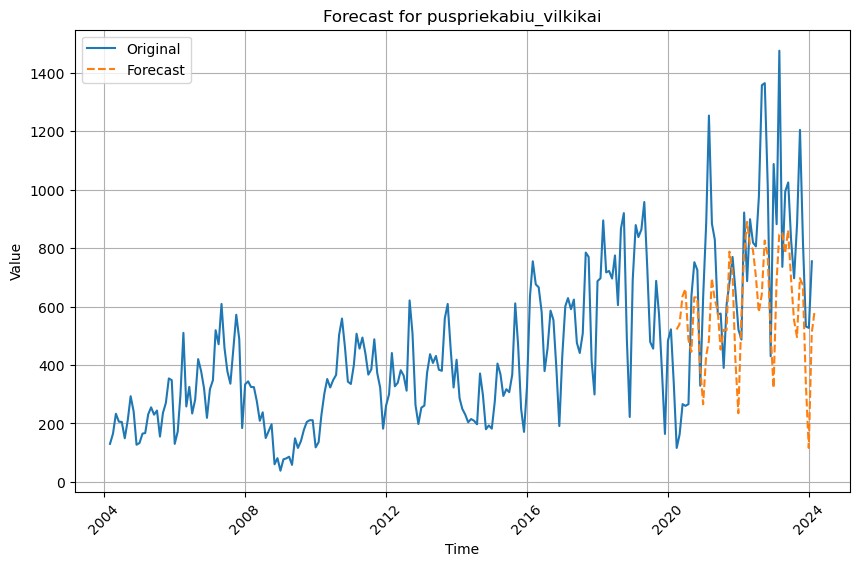

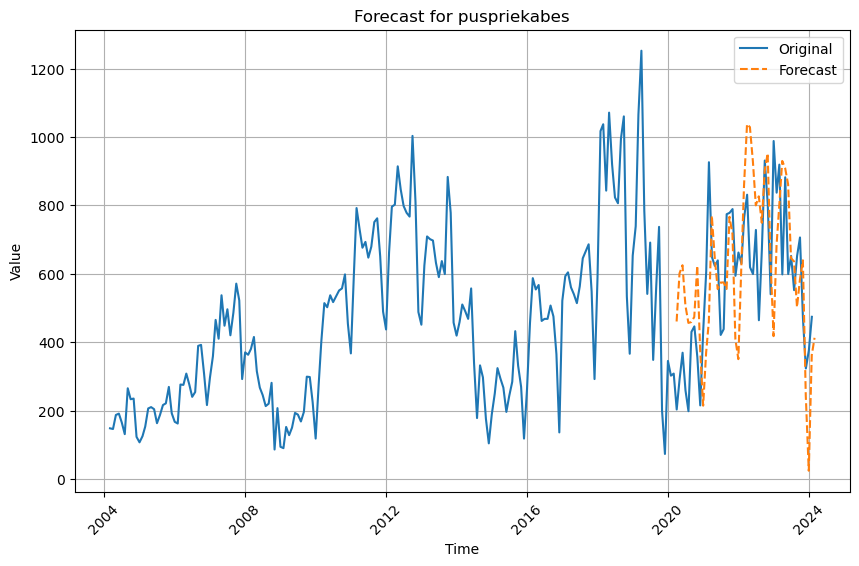

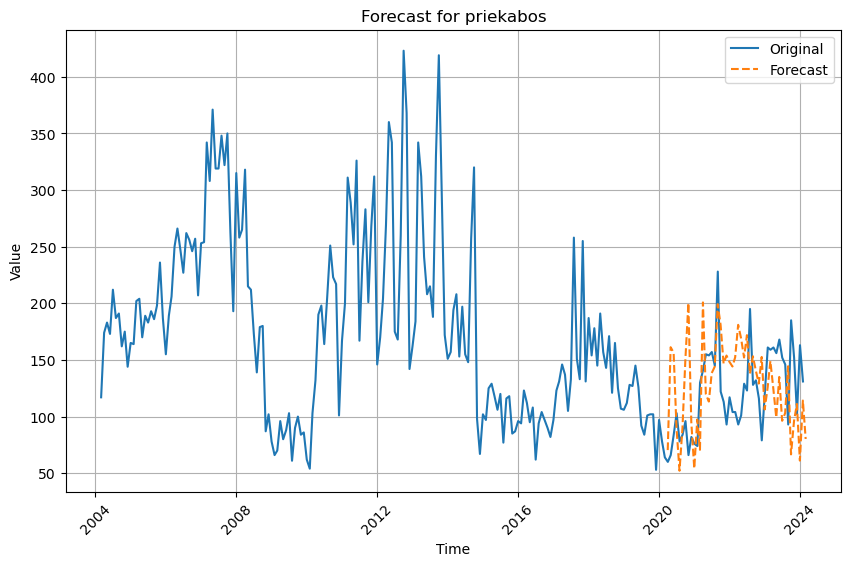

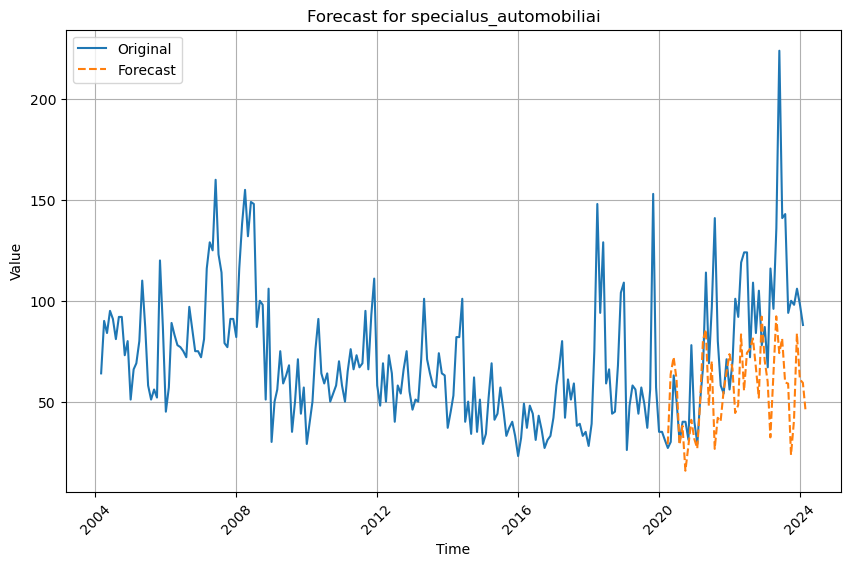


Forecasted Results:



trans_tipas   motociklai  lengvieji_automobiliai   autobusai  \
2020-03-31    562.592137            11218.450881   48.871551   
2020-04-30    831.525727            13279.173728   43.449315   
2020-05-31    788.263872            14212.699136   70.136372   
2020-06-30    610.428433            14430.818479   30.737285   
2020-07-31    547.228202            11787.305896   36.424411   
2020-08-31    524.705997            13359.767559  121.114236   
2020-09-30    338.777157            12055.338501   83.998073   
2020-10-31    159.083258            14217.851144   77.285015   
2020-11-30    131.204305            11756.998411   40.047631   
2020-12-31    211.037206            11367.059876   27.584048   
2021-01-31    175.224564            10203.955808   41.810749   
2021-02-28    179.359291             9013.345983   23.342674   
2021-03-31    580.762680            14090.857615  114.246339   
2021-04-30    951.159109            14065.429833  111.047803   
2021-05-31    834.166864            13940.807850   36.680055   
2021-06-30    748.940341            14712.833584   61.049732   
2021-07-31    609.549479            15072.433234   46.984365   
2021-08-31    470.787361            15040.557427  117.364844   
2021-09-30    319.320045            15443.157740   79.230595   
2021-10-31    260.476138            16038.596177   56.229490   
2021-11-30    140.086715            13881.101122   79.223635   
2021-12-31    165.684127            15235.849132   84.226763   
2022-01-31    121.119711            12281.849035   66.085958   
2022-02-28    180.970725            12691.280741   72.388175   
2022-03-31    623.940268            14615.882997  101.397114   
2022-04-30   1058.543328            16548.054326   88.633609   
2022-05-31    872.782548            15889.361708   47.516574   
2022-06-30    762.103920            17162.035461   55.139214   
2022-07-31    622.595481            17585.085984   68.793580   
2022-08-31    552.118565            18473.264485  143.276496   
2022-09-30    434.566061            16503.697421   70.796359   
2022-10-31    364.307240            17874.599263   99.450823   
2022-11-30    211.128587            16655.773459  125.475196   
2022-12-31    173.516627            14142.827801   66.172736   
2023-01-31    176.162889            12861.787555   48.702938   
2023-02-28    299.507251            13460.613037   77.912299   
2023-03-31    755.451089            15966.952089  106.325520   
2023-04-30   1147.621745            17540.116753   96.700191   
2023-05-31   1104.264913            18538.305583   75.411841   
2023-06-30    868.433977            17052.364410   43.772434   
2023-07-31    753.017862            16735.915585   31.729173   
2023-08-31    701.064464            17748.563848  116.592326   
2023-09-30    541.692463            15174.084450   59.161219   
2023-10-31    434.653326            17911.572695   62.139315   
2023-11-30    281.896759            16126.743892   77.626693   
2023-12-31    198.062244            13889.906870   31.894732   
2024-01-31    260.229988            13911.485624   42.717232   
2024-02-29    369.167908            13600.449118   58.985380   

trans_tipas  krovininiai_automobiliai  puspriekabiu_vilkikai  puspriekabes  \
2020-03-31                 735.010592             521.652612    460.333097   
2020-04-30                 918.764345             539.248360    600.946125   
2020-05-31                 883.185703             635.094492    624.835386   
2020-06-30                1022.510247             660.526213    507.655873   
2020-07-31                 641.588453             487.939428    456.160772   
2020-08-31                 827.714475             445.236393    458.817974   
2020-09-30                 828.290966             631.594941    473.483635   
2020-10-31                 997.214486             631.444965    623.189452   
2020-11-30                 865.197529             392.513506    378.577245   
2020-12-31                 772.352171             265.646908    214.205622   
2021-


Evaluation metrics for motociklai:
RMSE: 232.30738283964442
MAE: 181.53722735652437
R2 Score: 0.6612150368400846

Evaluation metrics for lengvieji_automobiliai:
RMSE: 4641.613408680193
MAE: 4083.5012773793314
R2 Score: -3.511464519452466

Evaluation metrics for autobusai:
RMSE: 43.230340514348505
MAE: 35.56773182226707
R2 Score: -3.556657248595652

Evaluation metrics for krovininiai_automobiliai:
RMSE: 171.3005378612091
MAE: 136.6888011192571
R2 Score: -0.7026210103929778

Evaluation metrics for puspriekabiu_vilkikai:
RMSE: 307.35367131185035
MAE: 254.16071473473002
R2 Score: 0.019143036168148053

Evaluation metrics for puspriekabes:
RMSE: 182.3225869831114
MAE: 143.61699611193464
R2 Score: 0.224362686229304

Evaluation metrics for priekabos:
RMSE: 47.96053893606472
MAE: 39.96017086711226
R2 Score: -0.6190059860174031

Evaluation metrics for specialus_automobiliai:
RMSE: 45.991802431928114
MAE: 35.41213385807904
R2 Score: -0.4168167345742744


In [130]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[1]  # Return the p-value

# Function to perform KPSS test with enhanced warning handling
def kpss_test(series):
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        result = kpss(series, regression='c', nlags='auto')
        for warning in w:
            if "p-value is smaller" in str(warning.message):
                return 0.01  # Return the smallest possible p-value
            elif "p-value is greater" in str(warning.message):
                return 1.0  # Return the largest possible p-value
    return result[1]  # Return the p-value

def check_stationarity(df):
    stationarity_results = {}
    for column in df.columns:
        series = df[column].dropna()
        adf_p_value = adf_test(series)
        kpss_p_value = kpss_test(series)
        is_stationary = adf_p_value < 0.05 and kpss_p_value > 0.05
        stationarity_results[column] = {
            'ADF p-value': adf_p_value,
            'KPSS p-value': kpss_p_value,
            'Is Stationary': is_stationary
        }
    return pd.DataFrame(stationarity_results).T

print('\nInitial Stationarity Check:\n')
stationarity_df = check_stationarity(train)
print(stationarity_df)

# Seasonal adjustment with STL
seasonal_periods = {'Annually': 13, 'Quarterly': 5}
stationarity_results_seasonally_adjusted = {}

for period_name, period_value in seasonal_periods.items():
    for column in train.columns:
        series = train[column].dropna()
        stl = STL(series, seasonal=period_value)
        result = stl.fit()

        seasonally_adjusted = series - result.seasonal

        adf_p_value = adf_test(seasonally_adjusted)
        kpss_p_value = kpss_test(seasonally_adjusted)
        is_stationary = adf_p_value < 0.05 and kpss_p_value > 0.05

        stationarity_results_seasonally_adjusted[f'{period_name}_{column}'] = {
            'ADF p-value': adf_p_value,
            'KPSS p-value': kpss_p_value,
            'Is Stationary': is_stationary
        }

        # Plot the decomposition for visualization
        plt.figure(figsize=(10, 6))
        plt.subplot(411)
        plt.plot(series, label='Original')
        plt.legend(loc='best')
        plt.subplot(412)
        plt.plot(result.trend, label='Trend')
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(result.seasonal, label='Seasonal')
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(result.resid, label='Residual')
        plt.legend(loc='best')
        plt.suptitle(f'{period_name} Seasonal Decomposition for {column}')
        plt.show()

stationarity_seasonally_adjusted_df = pd.DataFrame(stationarity_results_seasonally_adjusted).T
print(stationarity_seasonally_adjusted_df)

# Determine the best period based on the number of True values for stationarity
best_period = 'Annually'
max_stationary_count = 0

for period_name in seasonal_periods.keys():
    true_count = sum(stationarity_seasonally_adjusted_df[stationarity_seasonally_adjusted_df.index.str.startswith(period_name)]['Is Stationary'])
    print(f'{period_name} - True Count: {true_count}')

    if true_count > max_stationary_count:
        max_stationary_count = true_count
        best_period = period_name

print(f'\nBest Seasonal Period: {best_period} with {max_stationary_count} true stationary series')

deseasonalized_train = train.copy()
trend_components = {}
seasonal_components = {}

# Detrend and deseasonalize data using the best period
for column in train.columns:
    series = train[column].dropna()
    stl = STL(series, seasonal=seasonal_periods[best_period])
    result = stl.fit()

    deseasonalized_train[column] = series - result.seasonal
    trend_components[column] = result.trend
    seasonal_components[column] = result.seasonal

# Combine detrended data into one DataFrame
deseasonalized_data = deseasonalized_train.copy()

# Check stationarity of the deseasonalized data
print('\nStationarity Check for Deseasonalized Data:\n')
stationarity_df_deseasonalized = check_stationarity(deseasonalized_data)
display(stationarity_df_deseasonalized)

st_train = train.copy()

# Detrend and deseasonalize data using the best period
for column in train.columns:
    series = train[column].dropna()
    stl = STL(series, seasonal=seasonal_periods[best_period])
    result = stl.fit()

    st_train[column] = series - result.seasonal - result.trend

# Check stationarity of the deseasonalized and detrended data
print('\nStationarity Check for Deseasonalized and Detrended Data:\n')
stationarity_df_st = check_stationarity(st_train)
display(stationarity_df_st)

deseasonalized_data = st_train.copy()

# Variance Inflation Factor (VIF)
def calculate_vif(df):
    vif = pd.DataFrame()
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_df = calculate_vif(deseasonalized_data)
print('\nVariance Inflation Factor (VIF):\n')
display(vif_df)

# Drop columns with high VIF
def drop_high_vif_columns(df, threshold=5.0):
    while True:
        vif_data = calculate_vif(df)
        max_vif = vif_data['VIF'].max()
        if max_vif < threshold:
            break
        max_vif_column = vif_data.loc[vif_data['VIF'] == max_vif, 'variables'].values[0]
        print(f'Dropping column: {max_vif_column} with VIF: {max_vif}')
        df = df.drop(columns=[max_vif_column])
    return df, calculate_vif(df)

df_reduced, final_vif = drop_high_vif_columns(deseasonalized_data, threshold=5.0)
print('Final DataFrame after VIF reduction:')
display(df_reduced)
print('\nFinal VIF values:')
display(final_vif)

# Fit VAR model on the reduced DataFrame using training data
model = VAR(df_reduced)
fitted_model = model.fit(maxlags=15, ic='aic')
display(fitted_model.summary())

# Check for heteroskedasticity using ARCH test
arch_test_results = {}
residuals = fitted_model.resid
for column in residuals.columns:
    test_result = het_arch(residuals[column].dropna())
    arch_test_results[column] = {
        'Lagrange Multiplier p-value': test_result[1],
        'F-statistic p-value': test_result[3]
    }

arch_test_df = pd.DataFrame(arch_test_results).T
print('\nARCH Test Results:\n')
display(arch_test_df)

# Johansen Cointegration Test
def johansen_cointegration_test(df, det_order=-1, k_ar_diff=1):
    result = coint_johansen(df, det_order, k_ar_diff)
    trace_stat = result.lr1
    crit_value = result.cvt[:, 1]  # Critical value for 5% significance level
    result_df = pd.DataFrame({'Trace Statistic': trace_stat, 'Critical Value (5%)': crit_value})
    result_df['Is Cointegrated'] = result_df['Trace Statistic'] > result_df['Critical Value (5%)']
    return result_df

cointegration_result = johansen_cointegration_test(deseasonalized_data)
print('\nJohansen Cointegration Test:\n')
display(cointegration_result)

# Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
for column in residuals.columns:
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(residuals[column].dropna(), ax=plt.gca(), title=f'ACF of Residuals - {column}')
    plt.subplot(122)
    plot_pacf(residuals[column].dropna(), ax=plt.gca(), title=f'PACF of Residuals - {column}')
    plt.show()

# Forecasting the next 48 months (4 years) using the trained model
forecast_steps = 48
forecast_values = fitted_model.forecast(df_reduced.values[-fitted_model.k_ar:], steps=forecast_steps)
forecast_df = pd.DataFrame(forecast_values, 
                           index=pd.date_range(start=df_reduced.index[-1] + pd.DateOffset(months=1), 
                                               periods=forecast_steps, 
                                               freq='M'), 
                           columns=df_reduced.columns)

# Plotting the forecast on residuals
for column in forecast_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(deseasonalized_data.index, deseasonalized_data[column], label='Original Residuals')
    plt.plot(forecast_df.index, forecast_df[column], label='Forecasted Residuals', linestyle='--')
    plt.title(f'Forecast on Residuals for {column}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Add back the trend and seasonality to the forecasted values
for column in forecast_df.columns:
    forecast_df[column] = forecast_df[column] + trend_components[column].values[-forecast_steps:] + seasonal_components[column].values[-forecast_steps:]

# Plotting the forecast on original data
for column in forecast_df.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[column], label='Original')
    plt.plot(forecast_df.index, forecast_df[column], label='Forecast', linestyle='--')
    plt.title(f'Forecast for {column}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Print the forecasted results
print('\nForecasted Results:\n')
display(forecast_df)

# Evaluation metrics
for column in test.columns:
    rmse = np.sqrt(mean_squared_error(test[column], forecast_df[column][:len(test)]))
    mae = mean_absolute_error(test[column], forecast_df[column][:len(test)])
    r2 = r2_score(test[column], forecast_df[column][:len(test)])
    print(f'\nEvaluation metrics for {column}:')
    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'R2 Score: {r2}')
